# Importing Libraries

In [1]:
import numpy as np
import tensorflow as tf
import math
import logging
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import csv
from keras.utils import to_categorical
import keras_tuner as kt
import tensorflow as tf
from tensorflow import keras
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from numpy import absolute
from keras import losses
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score

# Data Preprocessing

In [2]:
# Reading the data
all_data=pd.read_excel('trainDataset.xls');
all_data.replace(999,np.nan, inplace=True)
#basic information on data and value types
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Columns: 120 entries, ID to original_ngtdm_Strength
dtypes: float64(116), int64(3), object(1)
memory usage: 375.1+ KB


In [3]:
#Drop id and pcr columns
all_data = all_data.drop("ID", axis=1)
all_data = all_data.drop("pCR (outcome)", axis=1)
all_data.head()

,RelapseFreeSurvival (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,LNStatus,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,144.0,41.0,0,0.0,0.0,1.0,3.0,3.0,1.0,1.0,...,0.517172,0.375126,3.325332,0.002314,3880771.500,473.464852,0.000768,0.182615,0.030508,0.000758
1,142.0,39.0,1,1.0,0.0,0.0,3.0,3.0,1.0,1.0,...,0.444391,0.444391,3.032144,0.005612,2372009.744,59.459710,0.004383,0.032012,0.001006,0.003685
2,135.0,31.0,0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,...,0.534549,0.534549,2.485848,0.006752,1540027.421,33.935384,0.007584,0.024062,0.000529,0.006447
3,12.0,35.0,0,0.0,0.0,1.0,3.0,3.0,1.0,1.0,...,0.506185,0.506185,2.606255,0.003755,6936740.794,46.859265,0.005424,0.013707,0.000178,0.004543
4,109.0,61.0,1,0.0,0.0,0.0,2.0,1.0,1.0,0.0,...,0.462282,0.462282,2.809279,0.006521,1265399.054,39.621023,0.006585,0.034148,0.001083,0.005626


# Replace missing values

In [4]:
# # Replace missing values with mean
# all_data['RelapseFreeSurvival (outcome)'] = all_data['RelapseFreeSurvival (outcome)'].fillna(all_data.mean(axis=0))
# all_data = all_data.fillna(all_data.mean(axis=0))

In [5]:
# find missing values
for col in all_data:
    if all_data[col].isnull().sum()>0:
        print(col,"has", all_data[col].isnull().sum(), "missing values")

PgR has 1 missing values
HER2 has 1 missing values
TrippleNegative has 1 missing values
ChemoGrade has 3 missing values
Proliferation has 2 missing values
HistologyType has 3 missing values
LNStatus has 1 missing values


In [6]:
# Replace missing values with mean
# all_data.fillna(all_data.mean())

# Use KNN to fill in missing values
imputer = KNNImputer(n_neighbors=2)
data_imp=imputer.fit_transform(all_data)
# filled missing values data
all_data = pd.DataFrame(data_imp,columns=all_data.columns,index=all_data.index)


#Use regression model for predicting missing features
# imputer1 = IterativeImputer(random_state=42)
# data_imp=imputer1.fit_transform(all_data)
# all_data = pd.DataFrame(data_imp,columns=all_data.columns,index=all_data.index)
all_data.describe()

,RelapseFreeSurvival (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,LNStatus,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.00000,400.000000,400.000000,...,4.000000e+02,4.000000e+02,4.000000e+02,400.000000,4.000000e+02,400.000000,400.000000,400.000000,400.000000,400.000000
mean,56.159792,51.851171,0.540000,0.402500,0.312500,0.335000,2.406250,1.58875,1.141250,0.518750,...,3.945420e-01,3.899257e-01,2.711993e+00,0.003314,5.683152e+07,176.969142,32500.032680,0.056721,0.005948,0.029385
std,26.763774,10.864462,0.499022,0.491016,0.464093,0.472582,0.501213,0.77330,0.347816,0.499647,...,1.674769e-01,1.624792e-01,7.556631e-01,0.002412,7.063822e+08,1045.305721,177545.921557,0.047363,0.008416,0.115909
min,5.000000,23.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.00000,1.000000,0.000000,...,7.050000e-11,7.050000e-11,-3.200000e-16,0.000008,0.000000e+00,0.000000,0.000248,0.000000,0.000000,0.000000
25%,38.000000,44.616016,0.000000,0.000000,0.000000,0.000000,2.000000,1.00000,1.000000,0.000000,...,3.199017e-01,3.175584e-01,2.330664e+00,0.001334,1.078546e+06,18.628013,0.001851,0.018628,0.000310,0.001535
50%,55.041667,51.119781,1.000000,0.000000,0.000000,0.000000,2.000000,1.00000,1.000000,1.000000,...,4.095627e-01,4.054695e-01,2.807355e+00,0.002888,3.366594e+06,66.507214,0.004399,0.047029,0.002301,0.003384
75%,73.000000,60.000000,1.000000,1.000000,1.000000,1.000000,3.000000,2.00000,1.000000,1.000000,...,5.000660e-01,4.962633e-01,3.277613e+00,0.004707,9.231697e+06,154.300334,0.013846,0.084418,0.007873,0.009558
max,144.000000,79.603012,1.000000,1.000000,1.000000,1.000000,3.000000,3.00000,2.000000,1.000000,...,8.773779e-01,8.571429e-01,4.947427e+00,0.011301,1.390001e+10,20764.693790,1000000.000000,0.285100,0.060742,1.145601


In [7]:
#separate ages into groups
if 'Age' in all_data.columns:
    bins = [18, 30, 40, 50, 60, 70, 120]
    labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70+']
    age_range = pd.cut(all_data['Age'], bins, labels = labels,include_lowest = True)

    le = LabelEncoder()
    age_range_enc=le.fit_transform(age_range)
    age_group =pd.DataFrame(age_range_enc,columns=['Age'])
    encoded = to_categorical(age_group)
    age_data = pd.DataFrame(encoded, columns = labels)
    for label in labels:
        all_data[label] = age_data[label]
    all_data.drop(['Age'], inplace=True, axis=1)
all_data

,RelapseFreeSurvival (outcome),ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,LNStatus,TumourStage,...,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,18-29,30-39,40-49,50-59,60-69,70+
0,144.000000,0.0,0.0,0.0,1.0,3.0,3.0,1.0,1.0,2.0,...,0.000768,0.182615,0.030508,0.000758,0.0,0.0,1.0,0.0,0.0,0.0
1,142.000000,1.0,1.0,0.0,0.0,3.0,3.0,1.0,1.0,2.0,...,0.004383,0.032012,0.001006,0.003685,0.0,1.0,0.0,0.0,0.0,0.0
2,135.000000,0.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,2.0,...,0.007584,0.024062,0.000529,0.006447,0.0,1.0,0.0,0.0,0.0,0.0
3,12.000000,0.0,0.0,0.0,1.0,3.0,3.0,1.0,1.0,3.0,...,0.005424,0.013707,0.000178,0.004543,0.0,1.0,0.0,0.0,0.0,0.0
4,109.000000,1.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,2.0,...,0.006585,0.034148,0.001083,0.005626,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,49.250000,0.0,0.0,0.0,1.0,3.0,3.0,1.0,1.0,4.0,...,0.003282,0.024716,0.000812,0.003078,0.0,0.0,1.0,0.0,0.0,0.0
396,48.500000,0.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,2.0,...,0.252582,0.007380,0.000037,0.231059,0.0,0.0,0.0,1.0,0.0,0.0
397,47.500000,1.0,0.0,0.0,0.0,3.0,3.0,1.0,1.0,3.0,...,0.001372,0.054063,0.003697,0.001368,0.0,0.0,0.0,0.0,1.0,0.0
398,46.916667,1.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,2.0,...,0.026591,0.018682,0.000311,0.022676,0.0,0.0,1.0,0.0,0.0,0.0


In [8]:
# Remove outliers
Q1 = all_data.quantile(0.05)
Q3 = all_data.quantile(0.95)
IQR = Q3 - Q1

all_data = all_data[~((all_data < (Q1 - 1.5 * IQR)) |(all_data > (Q3 + 1.5 * IQR))).any(axis=1)]

In [9]:
x = all_data.drop("RelapseFreeSurvival (outcome)", axis=1)
x.head()

,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,LNStatus,TumourStage,original_shape_Elongation,...,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,18-29,30-39,40-49,50-59,60-69,70+
0,0.0,0.0,0.0,1.0,3.0,3.0,1.0,1.0,2.0,0.813912,...,0.000768,0.182615,0.030508,0.000758,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,3.0,3.0,1.0,1.0,2.0,0.666118,...,0.004383,0.032012,0.001006,0.003685,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,2.0,0.645083,...,0.007584,0.024062,0.000529,0.006447,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,3.0,3.0,1.0,1.0,3.0,0.770842,...,0.005424,0.013707,0.000178,0.004543,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,2.0,0.861035,...,0.006585,0.034148,0.001083,0.005626,0.0,0.0,0.0,0.0,1.0,0.0


In [10]:
y = all_data["RelapseFreeSurvival (outcome)"]
y.head()

0    144.0
1    142.0
2    135.0
3     12.0
4    109.0
Name: RelapseFreeSurvival (outcome), dtype: float64

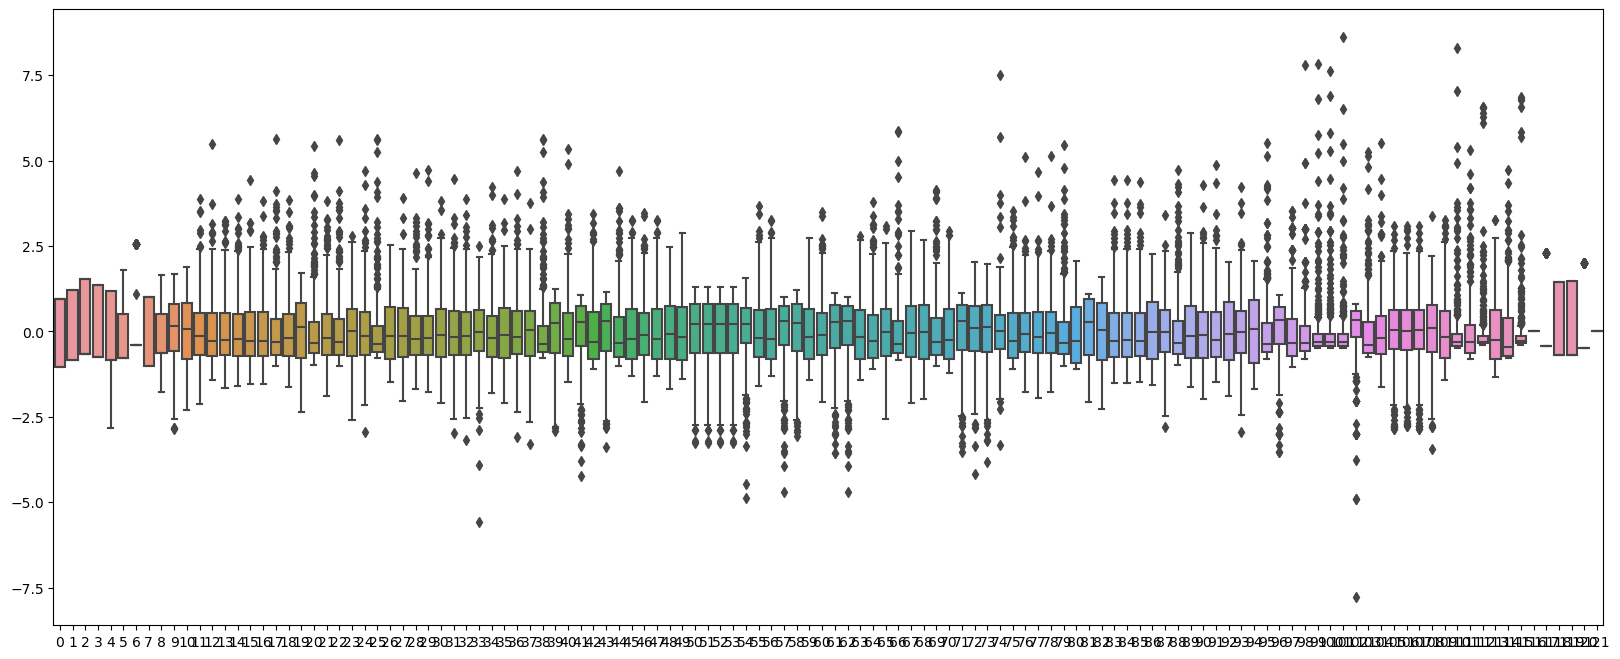

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
xs = scaler.fit_transform(x)
fig,ax=plt.subplots(1,figsize=(20,8))
sns.boxplot(data=xs,ax=ax)

## Feature Selection

In [12]:
# remove features with high variance
# select binary features that are either 1 or 0 more than 80% of the time
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
binary_data = x[['ER','PgR','HER2','TrippleNegative','18-29', '30-39', '40-49', '50-59', '60-69', '70+']]
sel.fit_transform(binary_data)

array([[0., 0., 0., ..., 1., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [13]:
from sklearn.ensemble import RandomForestRegressor

# feature importance using Randoom forest
rnd_reg = RandomForestRegressor(n_estimators=500, random_state=42)
rnd_reg.fit(x,y)

RandomForestRegressor(n_estimators=500, random_state=42)

In [14]:
feature_nme = []
feature_w = []
for score, name in zip(rnd_reg.feature_importances_, x.columns):
    score = round(score,2)
    # store the feature names and weights if the feature has a weight greater than zero
    if score>0:
        feature_nme.append(name)
        feature_w.append(score)
# create a dictionary of with the feature name as the key and the weight as the value
# 64 features in dictionary
rf_dict = {}
for i in range(len(feature_nme)):
    rf_dict.update({feature_nme[i]:feature_w[i]})


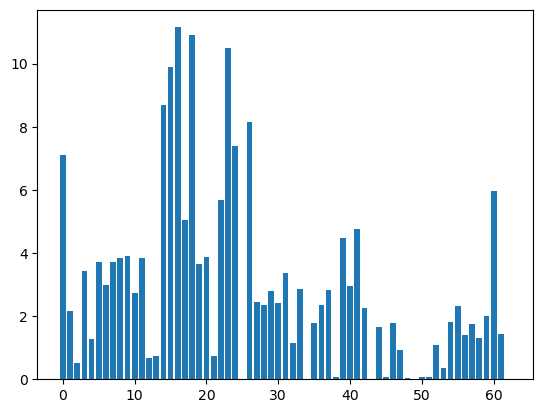

In [15]:
# Univariate feature selection

# configure to select all features
# change k to select the k best features
uv_fs = SelectKBest(score_func=f_regression, k=20)
# learn relationship from training data
uv_fs.fit(x[feature_nme], y)
# transform input data
x_fs1 = uv_fs.transform(x[feature_nme])
# plot a bar chart of the feature importance scores for each input feature
plt.bar([i for i in range(len(uv_fs.scores_))], uv_fs.scores_)
plt.show()

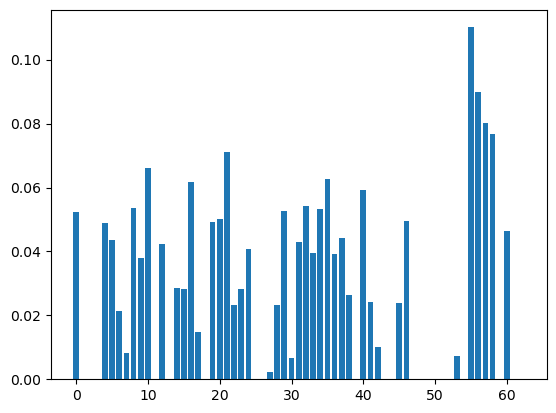

In [16]:
# mutual information feature selection
# configure to select all features
mi_fs = SelectKBest(score_func=mutual_info_regression, k=20)
# learn relationship from input data
mi_fs.fit(x[feature_nme],y)
# transform input data
x_fs2 = mi_fs.transform(x[feature_nme])
# plot the scores
plt.bar([i for i in range(len(mi_fs.scores_))], mi_fs.scores_)
plt.show()

In [17]:
from sklearn.preprocessing import MinMaxScaler
# perform min max normalisation on scores from univariate
# feature selection adn mutual information feature selection
mm_scaler = MinMaxScaler()
uv_fs_scores = mm_scaler.fit_transform(uv_fs.scores_.reshape(-1,1))
uv_fs_names= uv_fs.get_feature_names_out()

mi_fs_scores = mm_scaler.fit_transform(mi_fs.scores_.reshape(-1,1))
mi_fs_names= mi_fs.get_feature_names_out()

# create a dictionary to store the feature names
# and its normalized score and the value for univariate fs
uv_fs_dict = {}
for i in range(len(uv_fs_names)):
    uv_fs_dict.update({uv_fs_names[i]:uv_fs_scores[i][0]})

# create a dictionary to store the feature names
# and its normalized score and the value for mutual info fs
mi_fs_dict = {}
for i in range(len(mi_fs_names)):
    mi_fs_dict.update({mi_fs_names[i]:mi_fs_scores[i][0]})
# create a list with each features name from the random forest
# and a list for its score which is its rand_forest_score *(uni_score+mi+score)
final_score=[]
final_features=[]
for feature in feature_nme:
    uv_feat_score = uv_fs_dict.get(feature)
    mi_feat_score = mi_fs_dict.get(feature)
    # if the feature name is not in the list return zero
    if uv_feat_score is None:
        uv_feat_score=0
    if mi_feat_score is None:
        mi_feat_score=0
    final_features.append(feature)
    final_score.append(rf_dict.get(feature)*(uv_feat_score+mi_feat_score))

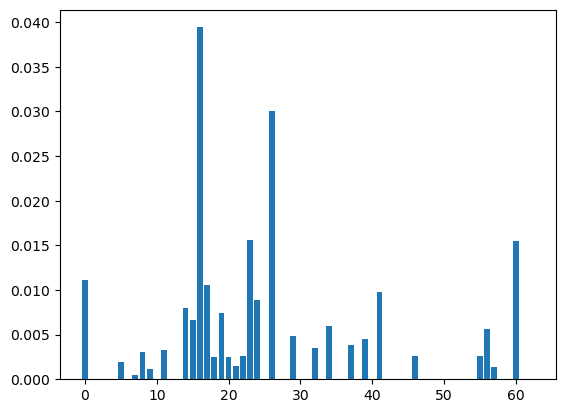

['Proliferation', 'original_firstorder_10Percentile', 'original_firstorder_Skewness', 'original_glcm_Correlation', 'original_glcm_Imc1', 'original_glcm_MCC', 'original_gldm_DependenceEntropy', 'original_gldm_DependenceNonUniformityNormalized', 'original_gldm_GrayLevelNonUniformity', 'original_gldm_LargeDependenceEmphasis', 'original_gldm_LargeDependenceLowGrayLevelEmphasis', 'original_glrlm_GrayLevelNonUniformity', 'original_glrlm_RunEntropy', 'original_glrlm_RunLengthNonUniformity', 'original_glrlm_RunLengthNonUniformityNormalized', 'original_glrlm_RunVariance', 'original_glrlm_ShortRunEmphasis', 'original_glrlm_ShortRunHighGrayLevelEmphasis', 'original_glrlm_ShortRunLowGrayLevelEmphasis', 'original_glszm_GrayLevelNonUniformity', 'original_glszm_GrayLevelVariance', 'original_glszm_HighGrayLevelZoneEmphasis', 'original_glszm_SizeZoneNonUniformity', 'original_glszm_SmallAreaLowGrayLevelEmphasis', 'original_glszm_ZoneEntropy', 'original_ngtdm_Busyness', 'original_ngtdm_Strength', 'origin

In [18]:
#order the feature names by their score value
sel_features=[final_features for _, final_features in sorted(zip(final_score, final_features))]
#plot the final scores
plt.bar([i for i in range(len(final_score))], final_score)
plt.show()
#64 feature in sel_features
print(sel_features)

## PCA

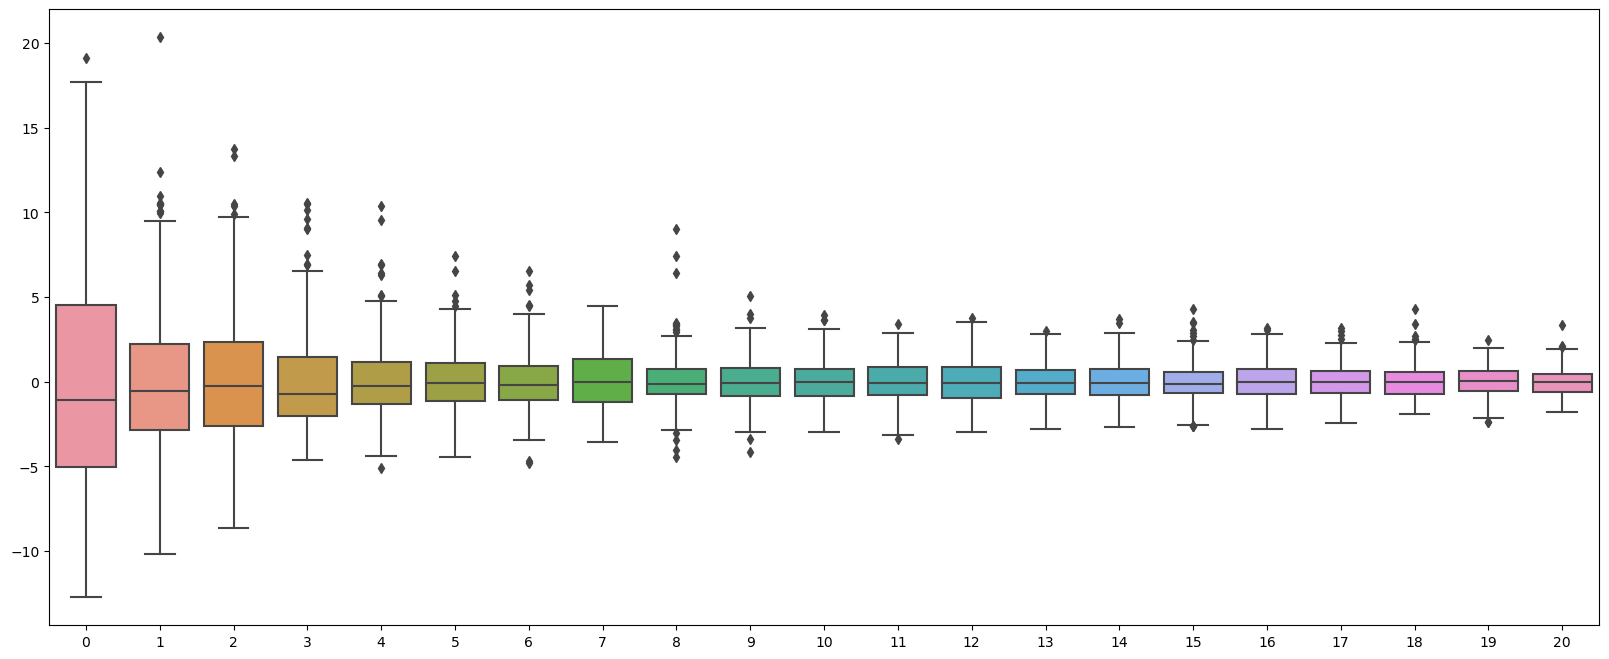

In [19]:
from sklearn.decomposition import PCA
feature_names = list(x.columns)
pca = PCA(.95)
xs_pca = pca.fit_transform(xs)
fig,ax=plt.subplots(1,figsize=(20,8))
sns.boxplot(data=xs_pca,ax=ax)

# Machine Learning Methods

In [20]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(xs_pca, y, test_size=0.3,random_state = 0)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(234, 21) (234,)
(101, 21) (101,)


## Linear Regression





In [21]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

n_folds = 5

model = LinearRegression().fit(x_train, y_train)

In [22]:
from sklearn.metrics import mean_absolute_error
y_pred = model.predict(x_test)
mean_absolute_error(y_test,y_pred)

24.981122648827494

In [23]:
scores_test = cross_val_score(model, xs_pca, y, scoring = 'neg_mean_absolute_error', cv=n_folds)
testScore_average= np.average(scores_test)

print(scores_test)
print('The {}-fold cross-validation accuracy score for this classifier is {:.2f}'.format(n_folds, absolute(testScore_average)))


[-45.45934732 -20.14780185 -13.49655333 -25.57380691 -16.02121145]
The 5-fold cross-validation accuracy score for this classifier is 24.14


## Decision Tree

In [24]:
from sklearn.tree import DecisionTreeRegressor

regressorTree = DecisionTreeRegressor(random_state = 0) 
  
regressorTree.fit(x_train, y_train)

DecisionTreeRegressor(random_state=0)

In [25]:
n_folds = 5

scores = cross_val_score(regressorTree, xs_pca, y, scoring = 'neg_mean_absolute_error', cv=n_folds)
cv_error = np.average(scores)
print(scores)
print('The {}-fold cross-validation accuracy score for this classifier is {:.2f}'.format(n_folds, absolute(cv_error)))

[-43.71641791 -33.41915423 -29.00373134 -24.11567164 -26.68532338]
The 5-fold cross-validation accuracy score for this classifier is 31.39


## SVM

In [26]:
X = x[sel_features[:7]]
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [27]:
print(sel_features[:7])

['Proliferation', 'original_firstorder_10Percentile', 'original_firstorder_Skewness', 'original_glcm_Correlation', 'original_glcm_Imc1', 'original_glcm_MCC', 'original_gldm_DependenceEntropy']


In [28]:
svm_reg = SVR()
svm_model = svm_reg.fit(x_train,y_train)

In [29]:
y_pred = svm_model.predict(x_test)
mae1 = mean_absolute_error(y_test,y_pred)
print("mean absolute error for SVM with untuned parameters = ", mae1)

mean absolute error for SVM with untuned parameters =  20.464168058652035


In [30]:
# tune the hyperparameters
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
grid = GridSearchCV(SVR(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid.fit(x_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.012 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.001 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.002 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.012 total time=   0.0s
[CV 5/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.002 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.1, kernel=rbf;, score=-0.018 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.1, kernel=rbf;, score=-0.002 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=0.1, kernel=rbf;, score=-0.004 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.004 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=0.1, kernel=rbf;, score=-0.006 total time=   0.0s
[CV 1/5] END ....C=0.1, gamma=0.01, kernel=rbf;, score=-0.020 total time=   0.0s
[CV 2/5] END ....C=0.1, gamma=0.01, kernel=rbf;

[CV 3/5] END ......C=1000, gamma=1, kernel=rbf;, score=-0.292 total time=   0.0s
[CV 4/5] END ......C=1000, gamma=1, kernel=rbf;, score=-0.242 total time=   0.0s
[CV 5/5] END ......C=1000, gamma=1, kernel=rbf;, score=-1.544 total time=   0.0s
[CV 1/5] END ....C=1000, gamma=0.1, kernel=rbf;, score=-0.196 total time=   0.0s
[CV 2/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.113 total time=   0.0s
[CV 3/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.015 total time=   0.0s
[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.061 total time=   0.0s
[CV 5/5] END ....C=1000, gamma=0.1, kernel=rbf;, score=-0.149 total time=   0.0s
[CV 1/5] END ...C=1000, gamma=0.01, kernel=rbf;, score=-0.099 total time=   0.0s
[CV 2/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.094 total time=   0.0s
[CV 3/5] END ...C=1000, gamma=0.01, kernel=rbf;, score=-0.036 total time=   0.0s
[CV 4/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.105 total time=   0.0s
[CV 5/5] END ...C=1000, gamm

GridSearchCV(estimator=SVR(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [31]:
grid_predictions = grid.predict(x_test)
# print best hyperparameters after tuning
print(grid.best_params_)
# print regression report
mae = mean_absolute_error(y_test, grid_predictions)
print("mean absolute error for SVM with tuned parameters = ", mae)

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}
mean absolute error for SVM with tuned parameters =  20.601348822831795


In [32]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5,shuffle=True,random_state=123)

svm_mse=-cross_val_score(svm_model, x_train, y_train, scoring = 'neg_mean_absolute_error', cv=kfold)
pd.Series(svm_mse).describe()

count     5.000000
mean     21.199357
std       1.091638
min      19.276075
25%      21.434582
50%      21.576033
75%      21.782235
max      21.927860
dtype: float64

## ANN

In [33]:
#init mlp and tune the params

def my_mlp(neurons, layers, learning_rate):
    neurons = round(neurons)
    layers = round(layers)
        
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    # build inital model   
    model = keras.Sequential()
    model.add(keras.layers.Dense(neurons, input_dim=7, activation="relu"))
    # create the number of layers equal to the value 'layers'
    for _ in range(layers):
        model.add(keras.layers.Dense(neurons, activation="relu"))
        
    model.add(keras.layers.Dense(1))
    model.compile(loss=losses.MeanAbsoluteError(reduction="auto", name="mean_absolute_error"), 
                  optimizer=optimizer, metrics = ["MeanAbsoluteError"])
    # perform early stopping to prevent overfitting
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    
    history=model.fit(x_train,y_train,epochs=100,verbose=0,validation_data=(x_test,y_test), 
                      callbacks = [early_stopping_cb])
    #return the mean validation score
    return -np.mean(history.history['val_loss'])

In [34]:
from bayes_opt import BayesianOptimization
params = {
    'neurons': (20,80),
    'layers': (0,15),
    'learning_rate': (1e-5,1e-2),
}
#Run Bayesian Optimisation
mlp_bo = BayesianOptimization(my_mlp,params,random_state=111)
mlp_bo.maximize(init_points=20,n_iter=2)

|   iter    |  target   |  layers   | learni... |  neurons  |
-------------------------------------------------------------
| 1         | -22.85    | 9.183     | 0.001699  | 46.16     |
| 2         | -27.28    | 11.54     | 0.00296   | 28.95     |
| 3         | -24.83    | 0.3372    | 0.004208  | 34.32     |
| 4         | -22.2     | 5.065     | 0.009907  | 34.26     |
| 5         | -22.11    | 1.218     | 0.006699  | 57.27     |
| 6         | -24.12    | 4.114     | 0.004668  | 27.1      |
| 7         | -23.22    | 1.109     | 0.009009  | 67.64     |
| 8         | -23.73    | 12.61     | 0.008154  | 79.46     |
| 9         | -22.08    | 8.659     | 0.00814   | 45.28     |
| 10        | -28.68    | 0.4117    | 0.004547  | 26.32     |
| 11        | -22.81    | 12.26     | 0.00698   | 53.92     |
| 12        | -22.25    | 4.113     | 0.009985  | 28.28     |
| 13        | -23.63    | 9.231     | 0.004856  | 44.3      |
| 14        | -23.69    | 10.92     | 0.003235  | 44.03     |
| 15    

In [35]:
# filter the optimum params
opt_params = mlp_bo.max['params']
opt_params['neurons'] = round(opt_params['neurons'])
opt_params['layers'] = round(opt_params['layers'])
opt_params['learning_rate'] = opt_params['learning_rate']
print("neurons=%d, layers=%d, learning_rate=%f"%
      (opt_params['neurons'],opt_params['layers'],opt_params['learning_rate']))

neurons=36, layers=9, learning_rate=0.010000


In [36]:
# Build a optimised multilayer perceptron neural network
opt_model = keras.models.Sequential()
opt_model.add(keras.layers.Dense(opt_params['neurons'], activation="relu"))
for _ in range(opt_params['layers']):
    opt_model.add(keras.layers.Dense(opt_params['neurons'], activation="relu"))
opt_model.add(keras.layers.Dense(1))

optimizer=keras.optimizers.Adam(learning_rate=opt_params['learning_rate'])
opt_model.compile(loss=losses.MeanAbsoluteError(reduction="auto", name="mean_absolute_error"), 
                optimizer=optimizer, metrics = ["MeanAbsoluteError"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history=opt_model.fit(x_train,y_train,epochs=100,verbose=0,
                      callbacks = [early_stopping_cb],validation_data=(x_test,y_test))

opt_model.summary()
opt_model.save_weights('my_model.h5')

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_196 (Dense)           (None, 36)                288       
                                                                 
 dense_197 (Dense)           (None, 36)                1332      
                                                                 
 dense_198 (Dense)           (None, 36)                1332      
                                                                 
 dense_199 (Dense)           (None, 36)                1332      
                                                                 
 dense_200 (Dense)           (None, 36)                1332      
                                                                 
 dense_201 (Dense)           (None, 36)                1332      
                                                                 
 dense_202 (Dense)           (None, 36)              

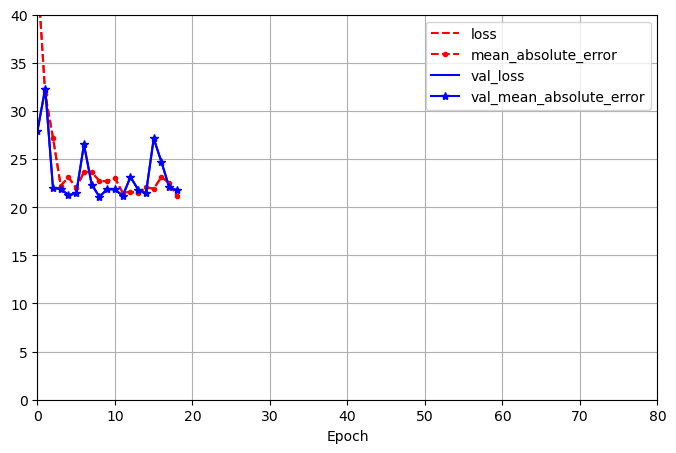

In [37]:
# visualise training process, loss and accuracy
pd.DataFrame(history.history).plot(
    figsize=(8, 5),xlim=[0,80],ylim=[0,40],grid=True, xlabel="Epoch",
    style=["r--","r--.","b-","b-*"]) 
plt.show()

In [38]:
krmodel = KerasRegressor(opt_model,epochs=40,verbose=0)
kfold = KFold(n_splits=5,shuffle=True,random_state=123)
ann_mse = -cross_val_score(krmodel, x_train, y_train, scoring = 'neg_mean_absolute_error', cv=kfold)
pd.Series(ann_mse).describe()

INFO:tensorflow:Assets written to: C:\Users\SKirt\AppData\Local\Temp\tmpqs_g4zcj\assets
INFO:tensorflow:Assets written to: C:\Users\SKirt\AppData\Local\Temp\tmpy1dg43f0\assets
INFO:tensorflow:Assets written to: C:\Users\SKirt\AppData\Local\Temp\tmpinhjbhdg\assets
INFO:tensorflow:Assets written to: C:\Users\SKirt\AppData\Local\Temp\tmpq9mm78gr\assets
INFO:tensorflow:Assets written to: C:\Users\SKirt\AppData\Local\Temp\tmpv2ju1w95\assets


count     5.000000
mean     22.198330
std       2.081983
min      19.433355
25%      21.283623
50%      22.368959
75%      22.797214
max      25.108496
dtype: float64

In [39]:
#Function called from test file to read test data, prepare it for the models to calculate the predictions
def best_eval(string):
    test_data=pd.read_excel(string, index_col=False)
    test_data = test_data.drop(["ID"], axis=1)
    test_data.replace(999, np.nan, inplace=True)
    data_imp=imputer.fit_transform(test_data)
    test_data = pd.DataFrame(data_imp,columns=test_data.columns,index=test_data.index)
    
    if 'Age' in test_data.columns:
        bins = [18, 30, 40, 50, 60, 70, 120]
        labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70+']
        age_range = pd.cut(test_data['Age'], bins, labels = labels,include_lowest = True)

        le = LabelEncoder()
        age_range_enc=le.fit_transform(age_range)
        age_group =pd.DataFrame(age_range_enc,columns=['Age'])
        encoded = to_categorical(age_group)
        age_data = pd.DataFrame(encoded, columns = labels)
        for label in labels:
            test_data[label] = age_data[label]
        
        test_data.drop(['Age'], inplace=True, axis=1)
    
    
    test_data = test_data[sel_features[:7]]
    
    pred = opt_model.predict(test_data)
    return pred